In [1]:
import sys
sys.path.insert(1,'..')

import models
import inference
import loader 
import jax
import jax.numpy as jnp
from numpyro import optim
import utils

import visualizations
import yaml
import os
import evaluation
import numpyro

%load_ext autoreload
%autoreload 2

/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Some global parameters

seed=0 # for reproducibility
save=False # save plots in the file 
file='../../results/gpwp/' # file address for saving

In [3]:
# Load parameter configuration from the config file

config = '../configs/GPWP.yaml'
with open(config, 'r') as stream: pm = yaml.safe_load(stream)
dataset_params, model_params, variational_params, visualization_params, comparison_params = pm['dataset_params'], pm['model_params'], pm['variational_params'], pm['visualization_params'], pm['comparison_params']

In [4]:
# Create a data loader that generates synthetic data based on the parameters in the config file (configs/GPWP.yaml)

dataloader = loader.GPWPLoader(dataset_params)
x,y = dataloader.load_data()
x_test, y_test = dataloader.load_test_data()

In [5]:
# Create instances of prior models (GP, WP) and likelihood and joint models using the parameters in the config file (configs/GPWP.yaml)

gp_kernel = utils.get_kernel(model_params['gp_kernel'],model_params['gp_kernel_diag'])
N = y.shape[2]

print('Trials, Conditions, Neurons: ', y.shape)

gp = models.GaussianProcess(kernel=gp_kernel,N=N)
empirical = jnp.cov((y - y.mean(0)[None]).reshape(y.shape[0]*y.shape[1],y.shape[2]).T)

wp_kernel = utils.get_kernel(model_params['wp_kernel'],model_params['wp_kernel_diag'])
wp_sample_diag = model_params['wp_sample_diag'] if 'wp_sample_diag' in model_params else 1e0

P = model_params['P'] if 'P' in model_params.keys() else model_params['P_scale']*N
optimize_L = True if 'optimize_L' in model_params.keys() and model_params['optimize_L'] else False

V = empirical+wp_sample_diag*jnp.eye(N)

wp = eval('models.'+model_params['prior'])(
    kernel=wp_kernel,P=P,
    V=V, optimize_L=optimize_L,
    diag_scale=wp_sample_diag
)

likelihood = eval('models.'+model_params['likelihood'])(N)
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

print(gp.evaluate_kernel(x,x).max())
print(wp.evaluate_kernel(x,x).max())

Trials, Conditions, Neurons:  (8, 40, 100)
1.001
1.001


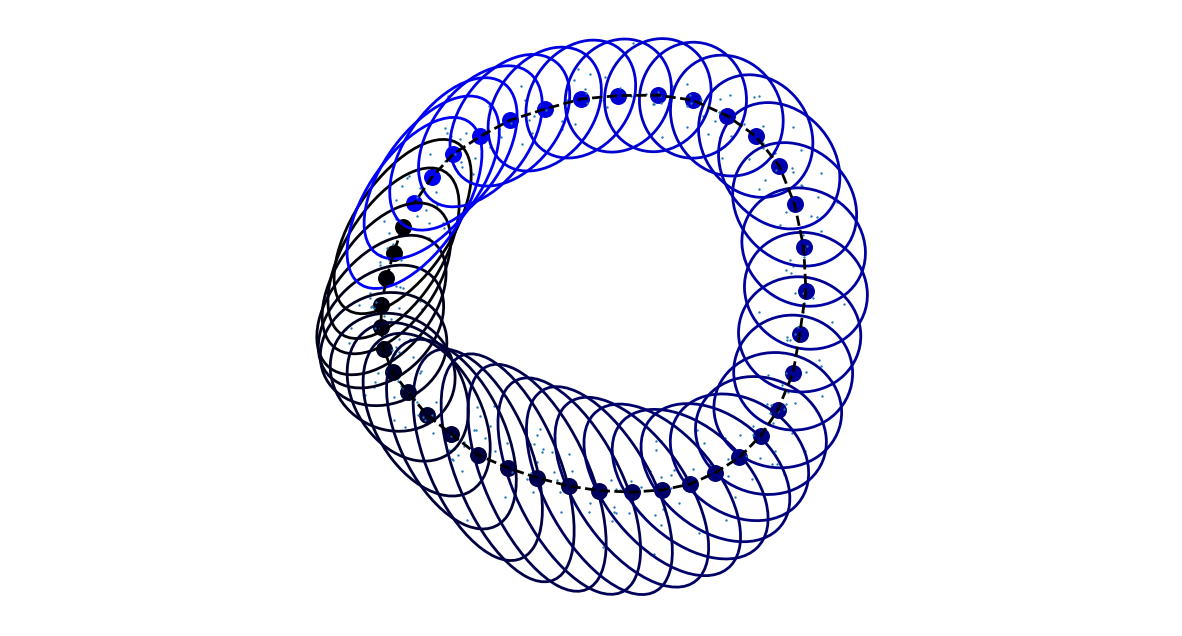

In [19]:
# Plot the true means and covariances, and data trials

visualizations.visualize_pc(
    jnp.concatenate((dataloader.mu,dataloader.mu_test))[:,None],
    jnp.concatenate((dataloader.sigma,dataloader.sigma_test)),
    pc=y.reshape(y.shape[0]*y.shape[1],-1),
    dotsize=500,
    linewidth=2
)

/mnt/home/anejatbakhsh/Desktop/Projects/Wishart-Process/codes/examples/../inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/50000 [00:00<?, ?it/s]/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 50000/50000 [00:55<00:00, 894.84it/s, init loss: 4043212.5000, avg. loss [47501-50000]: -7730.9002]


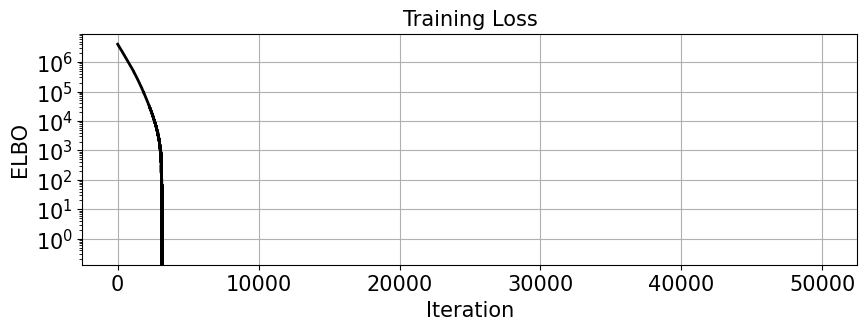

In [6]:
# Initialize the variational family and run posterior inference and plot ELBO loss
init = {'G':y.mean(0).T[:,None]}

varfam = eval('inference.'+variational_params['guide'])(
    joint.model,init=init
)
optimizer = eval('optim.'+variational_params['optimizer']['type'])(
    variational_params['optimizer']['step_size']
)
key = jax.random.PRNGKey(seed)

varfam.infer(
    optimizer,x.squeeze(),y,
    n_iter=variational_params['n_iter'],key=key,
    num_particles=variational_params['num_particles']
)
joint.update_params(varfam.posterior)

visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',
    titlestr='Training Loss',colors=['k'],
)


/mnt/home/anejatbakhsh/Desktop/Projects/Wishart-Process/codes/examples/../visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


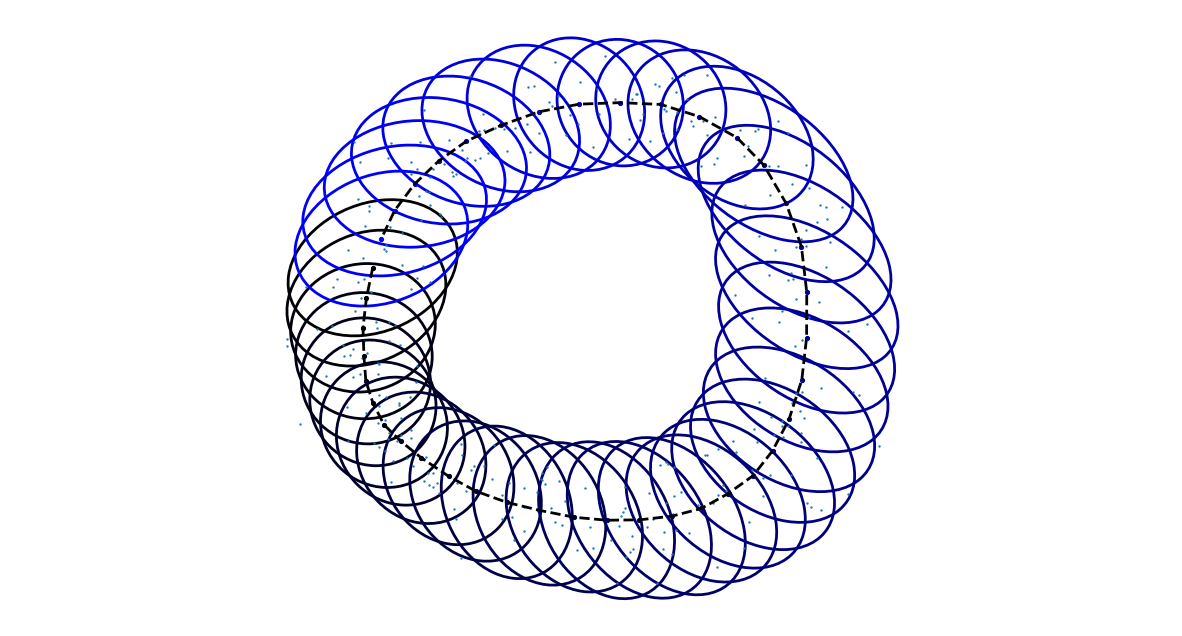

In [7]:
# Create the posterior distribution instance and sample from it in train and test conditions and plot it
posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(x)
    mu_prime, sigma_prime = posterior.derivative(x)

with numpyro.handlers.seed(rng_seed=seed):
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(x_test)
    mu_test_prime, sigma_test_prime = posterior.derivative(x_test)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,
    pc=y.reshape(y.shape[0]*y.shape[1],-1),
)

/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.416e-02
  warnings.warn(
/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:132: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005096220893349823, tolerance: 0.004581825242864437
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:132: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1817524843377214, tolerance: 0.022796473687781267
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/sklearn/covariance/_grap

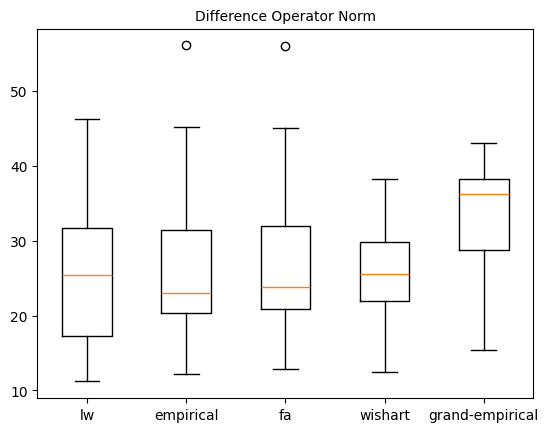

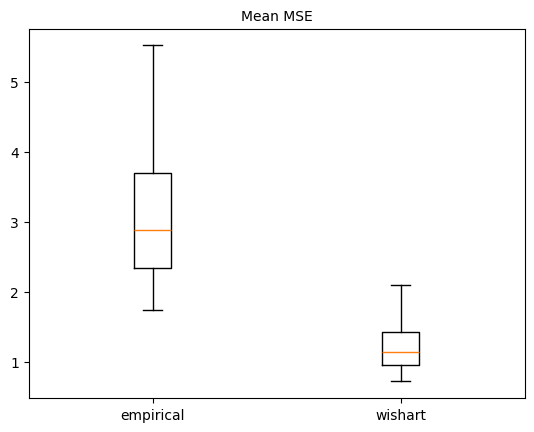

In [8]:
# Evaluate the performance of mean and covariance estimationthe model using MSE and operator norm

compared = evaluation.compare(y,params=comparison_params)
compared['wishart'] = sigma_hat.transpose(1,2,0)
compared['grand-empirical'] = jnp.repeat(empirical[:,:,None],y.shape[1],2)

performance = evaluation.evaluate(compared,dataloader.sigma.transpose(1,2,0))

visualizations.plot_box(
    performance,titlestr='Difference Operator Norm',
)

mse = lambda x,y: jnp.sqrt(((x-y)**2).sum(-1))

mu_empirical = y.mean(0)
performance_mean = {}
performance_mean['empirical'] = mse(mu_empirical,dataloader.mu)
performance_mean['wishart'] = mse(mu_hat,dataloader.mu)

visualizations.plot_box(
    performance_mean,titlestr='Mean MSE',
    save=save,file=file+'comparison'
)

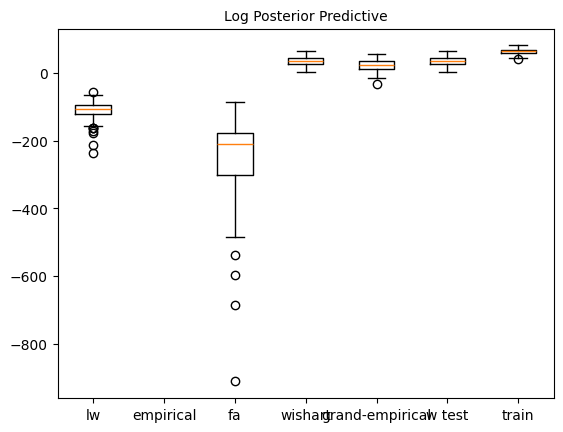

In [9]:
# Compute log likelihood on test trials for evaluation

lpp = {}
mu_empirical = y.mean(0)

for key in compared.keys():
    lpp[key] = likelihood.log_prob(y_test['x'],mu_empirical,compared[key].transpose(2,0,1)).flatten()

lpp['w test'] = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()
lpp['train'] = likelihood.log_prob(y,dataloader.mu,dataloader.sigma).flatten()

visualizations.plot_box(
    lpp,titlestr='Log Posterior Predictive',
)